# 1. 데이터 불러오기

## 목표 설정
---
**비즈니스 문제** : 카드 거래량 폭증과 고도화된 사기 패턴, 그리고 데이터 불균형(Class Imbalance) 특성으로 인해 기존 규칙 기반 모니터링의 한계가 발생함에 따라, 선제적 대응이 가능한 데이터 기반 자동 탐지 시스템이 필요하다.

**분석 목표** : 거래 정보 및 고객 데이터를 활용한 사기 발생 주요 요인 파악 및 불균형 데이터 특성을 고려한 이상 거래 탐지 모델 만들기

**성공 지표** : 단순 정확도가 아닌 PR-AUC 및 Recall 중심의 성능 확보와 오탐 최소화를 통한 탐지율과 고객 경험 간의 최적 임계값 설정

---

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os

df_fraud = pd.read_csv('fraud.csv')

target_col = 'is_fraud'

In [50]:
print("데이터 컬럼 :", df_fraud.columns)

df_fraud.head()

데이터 컬럼 : Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
1,2019-01-01 00:12:34,4956828990005111019,"fraud_Schultz, Simonis and Little",grocery_pos,44.71,Kenneth,Robinson,M,269 Sanchez Rapids,Elizabeth,...,40.6747,-74.2239,124967,Operational researcher,1980-12-21,09eff9c806365e2a6be12c1bbab3d70e,1325376754,40.079588,-74.848087,0
2,2019-01-01 00:17:16,180048185037117,fraud_Kling-Grant,grocery_net,46.28,Mary,Wall,F,2481 Mills Lock,Plainfield,...,40.6152,-74.4150,71485,Leisure centre manager,1974-07-19,19e23c6a300c774354417befe4f31f8c,1325377036,40.021888,-74.228188,0
3,2019-01-01 00:20:15,374930071163758,fraud_Deckow-O'Conner,grocery_pos,64.09,Daniel,Escobar,M,61390 Hayes Port,Romulus,...,42.2203,-83.3583,31515,Police officer,1971-11-05,6f363661ba6b55889e488dd178f2a0af,1325377215,42.360426,-83.552316,0
4,2019-01-01 00:23:41,2712209726293386,fraud_Balistreri-Nader,misc_pos,25.58,Jenna,Brooks,F,50872 Alex Plain Suite 088,Baton Rouge,...,30.4066,-91.1468,378909,"Designer, furniture",1977-02-22,1654da2abfb9e79a5f99167fc9779558,1325377421,29.737426,-90.853194,0


In [51]:
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  491134 non-null  object 
 1   cc_num                 491134 non-null  int64  
 2   merchant               491134 non-null  object 
 3   category               491134 non-null  object 
 4   amt                    491134 non-null  float64
 5   first                  491134 non-null  object 
 6   last                   491134 non-null  object 
 7   gender                 491134 non-null  object 
 8   street                 491134 non-null  object 
 9   city                   491134 non-null  object 
 10  state                  491134 non-null  object 
 11  zip                    491134 non-null  int64  
 12  lat                    491134 non-null  float64
 13  long                   491134 non-null  float64
 14  city_pop               491134 non-nu

In [52]:
# 기술통계량
exclude_cols = ["cc_num", "zip", "unix_time"]
num_cols = df_fraud.select_dtypes(include=["int64", "float64"]).columns
num_cols = [col for col in num_cols if col not in exclude_cols]

df_fraud[num_cols].describe()


,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud
count,491134.000000,491134.000000,491134.000000,4.911340e+05,491134.000000,491134.000000,491134.000000
mean,69.050120,37.931230,-90.495619,1.213922e+05,37.930272,-90.495411,0.002533
std,160.322867,5.341193,12.990732,3.725751e+05,5.372986,13.004100,0.050264
min,1.000000,24.655700,-122.345600,4.600000e+01,23.655789,-123.345106,0.000000
25%,8.960000,33.746700,-97.235100,1.228000e+03,33.781388,-96.984814,0.000000
50%,42.170000,38.507200,-87.591700,5.760000e+03,38.545124,-87.573441,0.000000
75%,80.330000,41.520500,-80.731000,5.083500e+04,41.624294,-80.685567,0.000000
max,25086.940000,48.887800,-69.965600,2.906700e+06,49.887523,-68.965624,1.000000


In [53]:
# 하버사인 거리 계산
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df_fraud["distance_km"] = haversine(
    df_fraud["lat"], df_fraud["long"],
    df_fraud["merch_lat"], df_fraud["merch_long"]
)

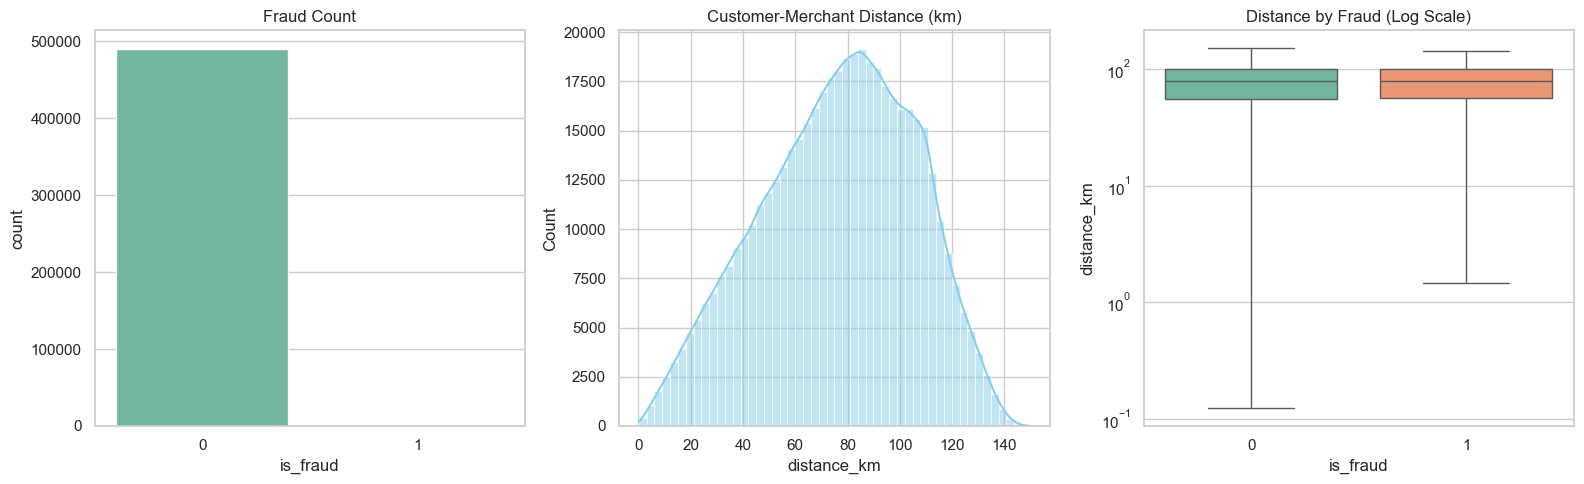

In [54]:
# 시각화
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

sns.set(style="whitegrid")

plt.figure(figsize=(16, 5))

# is_fraud 분포
plt.subplot(1, 3, 1)
sns.countplot(data=df_fraud, x='is_fraud', hue='is_fraud', palette='Set2', legend=False)
plt.title("Fraud Count")

# 거리 분포
plt.subplot(1, 3, 2)
sns.histplot(df_fraud["distance_km"], bins=50, kde=True, color='skyblue')
plt.title("Customer-Merchant Distance (km)")

# 사기 여부에 따른 거리 비교
plt.subplot(1, 3, 3)
sns.boxplot(data=df_fraud, x="is_fraud", y="distance_km", hue='is_fraud', palette='Set2', legend=False)
plt.yscale("log")
plt.title("Distance by Fraud (Log Scale)")

plt.tight_layout()
plt.show()


---
💡 **최단거리 구하기 - 하버사인 공식**
- 위도와 경도는 3차원 구면 위를 나타내는 좌표이다. 흔히 사용하는 유클리드 거리는 2차원 평면을 가정하기 때문에, 지구 표면처럼 둥근 공간에서 두 점 사이의 거리를 잴 때 곡률에 의한 오차가 발생한다.
- 이러한 오차를 반영하여 구면 위 두 지점간 최단 거리를 계산하는 공식이 하버사인 공식이다.
- 지구의 반경을 $R$, 두 지점의 위도와 경도를 각각 $\phi_1, \phi_2$ 및 $\lambda_1, \lambda_2$ (라디안)라고 할 때, 수식은 다음과 같이 표현된다.
  $$d = 2R \arcsin\left(\sqrt{\sin^2\left(\frac{\phi_2 - \phi_1}{2}\right) + \cos(\phi_1)\cos(\phi_2)\sin^2\left(\frac{\lambda_2 - \lambda_1}{2}\right)}\right)$$

- 신용거래 데이터에서 이 공식을 사용하는 이유는, 이상 탐지에서 하버사인 거리가 사기 거래를 잡아내는데 효과적이기 때문이다.
  - 예를 들어, 연속된 결제 내역의 장소가 물리적으로 이동 불가능한 거리에 있을 경우 카드를 복제했더나 도용했을 가능성이 있다. 이때 하버사인 거리를 구하고 결제 시간 차이로 나누면 '필요한 이동 시간'을 구할 수 있다.
  - 또한 정상적인 소비자는 대부분 자신의 집이나 직장 등 생활반경 내에서 사용하기 때문에, 평소 소비 패턴의 범위를 크게 벗어난다면 사기 거래로 의심할 수 있다.
- 기술통계량과 하버사인 거리를 같이 사용할 경우 더 정교한 파생변수를 만들 수 있다.
  - 각 고객별로 과거 결제 위치들 간의 평균 하버사인 거리와 표준편차를 구하고, 새로운 결제가 발생했을 때 이 결제 위치가 해당 고객의 쳥균적인 이동에서 몇 표준편차만큼 떨어져있는지 계산하면 단순 여행이 아니라 이상 거래일 가능성이 있다고 판단하는 기준을 세울 수 있다.



---

---
💡 **기술통계량 확인**
- `is_fraud`의 평균이 0.002533이 나온 것을 보아 사기 비율이 극단적으로 낮은 것을 알 수 있다. 심각한 클래스 불균형을 이루고 있으며, 단순 정확도(accuracy)는 큰 의미를 가지지 못한다.
  - 따라서 평가 지표는 Precision, Recall, F1 그리고 ROC-AUC보다 PR-AUC 로 평가하는 것이 좋다.
- 거래 금액 `amt`가 많이 치우친 것을 보아 이상치가 존재한다고 볼 수 있다.
- `distance_km`는 `amt`처럼 치우치진 않았지만, 크기가 크고 분포가 좁다
- `city_pop`또한 편차가 큰 것을 확인할 수 있는데, 이는 일부 대도시가 섞여서 평균을 끌어올렸기 때문으로 보인다.
---

# 2. 데이터 전처리

## 결측치 처리

In [55]:
print(df_fraud.isnull().sum())

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
distance_km              0
dtype: int64


## 이상치 탐지 및 처리

### 📌 불필요한 컬럼 제거 및 파생변수 생성

In [56]:
# 시간 변수 활용
df_fraud['trans_date_trans_time'] = pd.to_datetime(df_fraud['trans_date_trans_time'])
df_fraud['trans_hour'] = df_fraud['trans_date_trans_time'].dt.hour
df_fraud['is_night_txn'] = df_fraud['trans_hour'].apply(lambda x: 1 if (x >= 22 or x <= 5) else 0)

In [57]:
# 공간 변수 활용
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0 # 지구 반지름
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

df_fraud['distance_km'] = haversine_distance(
    df_fraud['lat'], df_fraud['long'], df_fraud['merch_lat'], df_fraud['merch_long']
)

In [58]:
# 인구 통계 활용
df_fraud['dob'] = pd.to_datetime(df_fraud['dob'])
df_fraud['age'] = (df_fraud['trans_date_trans_time'] - df_fraud['dob']).dt.days // 365

In [59]:
# 컬럼 제거 : 개인 식별 정보 및 이미 피처로 변환한 데이터
cols_to_drop = [
    'trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 
    'zip', 'dob', 'trans_num', 'unix_time', 
    'lat', 'long', 'merch_lat', 'merch_long'
]
df_fraud = df_fraud.drop(columns=cols_to_drop, errors='ignore')

그룹별 평균 비교

In [60]:
features = ['distance_km', 'age', 'is_night_txn', 'trans_hour']

insight_mean = df_fraud.groupby('is_fraud')[features].mean()

print("정상 vs 사기 그룹별 평균 비교")
print(insight_mean)

insight_median = df_fraud.groupby('is_fraud')[features].median()
print("\n정상 vs 사기 그룹별 중앙값 비교")
print(insight_median)

정상 vs 사기 그룹별 평균 비교
          distance_km        age  is_night_txn  trans_hour
is_fraud                                                  
0           76.377667  34.673612      0.259191   14.129580
1           76.763829  33.829582      0.868167   11.565916

정상 vs 사기 그룹별 중앙값 비교
          distance_km   age  is_night_txn  trans_hour
is_fraud                                             
0           78.538018  35.0           0.0        15.0
1           78.790257  34.0           1.0         8.5


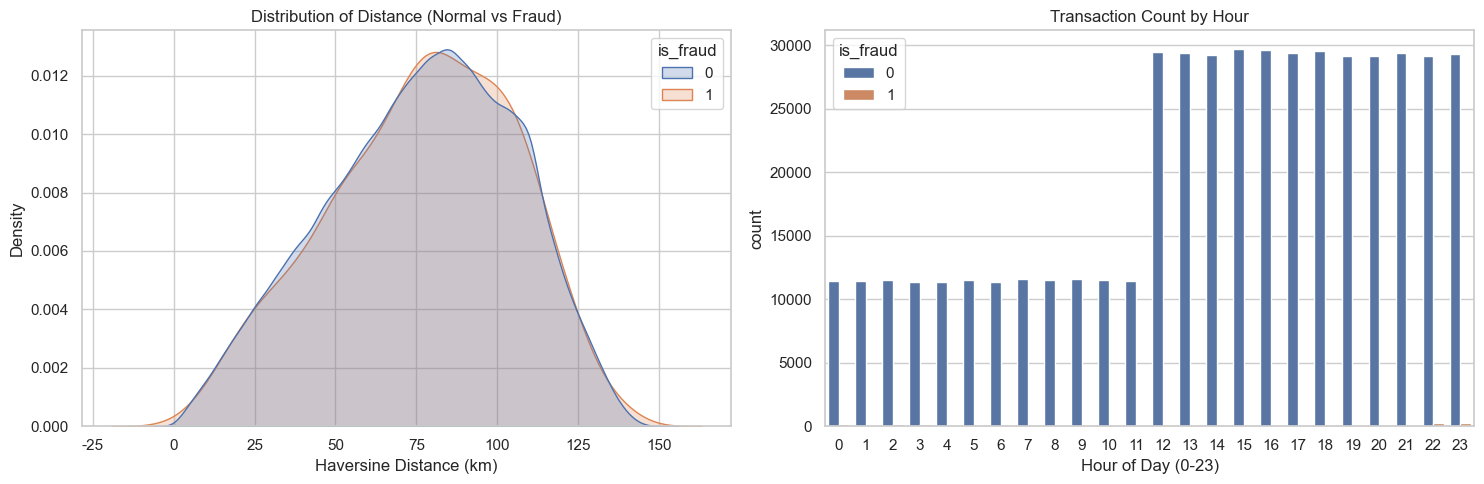

In [61]:
# 시각화
plt.figure(figsize=(15, 5))

# 하버사인 거리 분포
plt.subplot(1, 2, 1)
sns.kdeplot(data=df_fraud, x='distance_km', hue='is_fraud', common_norm=False, fill=True)
plt.title('Distribution of Distance (Normal vs Fraud)')
plt.xlabel('Haversine Distance (km)')

# 결제 시간대별 사기
plt.subplot(1, 2, 2)
sns.countplot(data=df_fraud, x='trans_hour', hue='is_fraud')
plt.title('Transaction Count by Hour')
plt.xlabel('Hour of Day (0-23)')

plt.tight_layout()
plt.show()

- 정상(0)그룹과 사기(1)그룹의 분포가 거의 겹치는 것을 보아, 단순한 직선 거리 `distance_km`만으로는 정상과 사기를 구분하기 어려울 것이다.
  - 사기범들은 사용자의 일반적인 행동 반경 내의 정보를 도용했을 가능성이 높다. 따라서 단순 거리보다는 이동 속도나, 평소 가지않던 새로운 지역 같은 변수가 더 주요하게 작용할 수 있다.
- 파란색 막대는 정상거래이고 주황색 막대는 사기거래를 나타내는데, 주황색 막대가 거의 보이지 않는 것을 보아 데이터 불균형 상황을 그래프로 확인할 수 있다.
- 오전 0시부터 11시까지는 거래량이 일정하다가, 낮 12시를 기점으로 거래량이 급증하여 밤까지 유진된다.
- 잘 보이지는 않지만 밤시간대에 주황색 막대도 조금 올라가는데, 이는 심야시간대 사기 거래가 올라간다고 볼 수 있다. `is_night_txn`변수에 주목할 필요가 있어보인다.

### 📌 이상치 탐지 및 처리

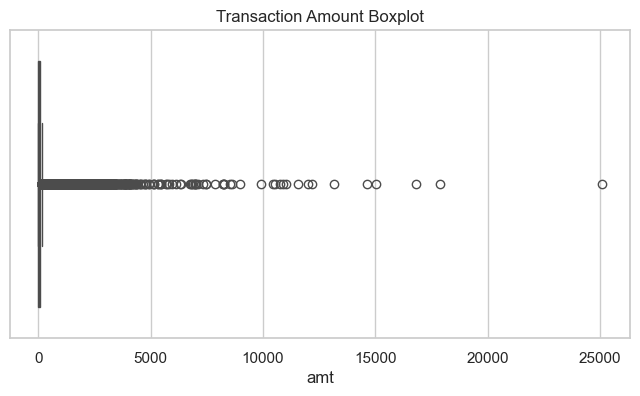

In [62]:
# 거래 금액(amt) 분포 확인
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_fraud['amt'])
plt.title('Transaction Amount Boxplot')
plt.show()

In [63]:
# IQR 이상치 제거
df_iqr = df_fraud.copy()

Q1 = df_iqr['amt'].quantile(0.25)
Q3 = df_iqr['amt'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df_iqr = df_iqr[(df_iqr['amt'] >= lower) & (df_iqr['amt'] <= upper)]

print("IQR 적용 전:", df_fraud.shape)
print("IQR 적용 후:", df_iqr.shape)

IQR 적용 전: (491134, 13)
IQR 적용 후: (456334, 13)


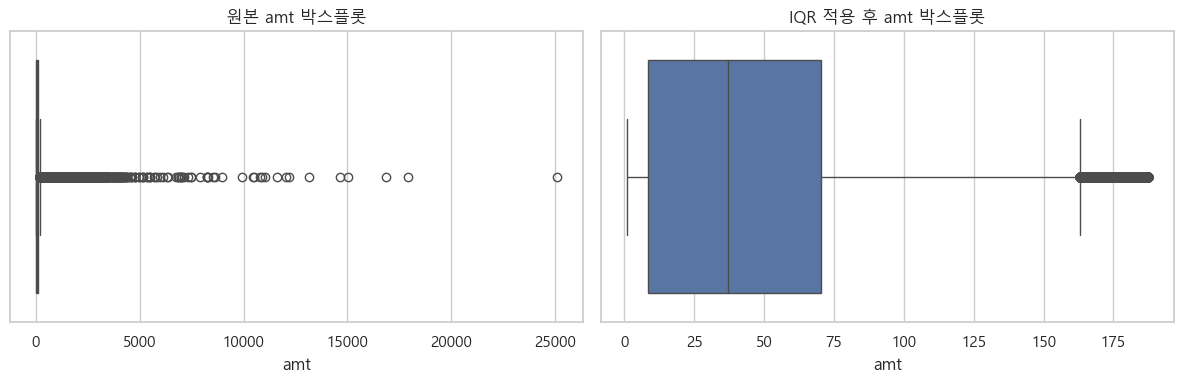

In [64]:
# IQR 전후비교 시각화
plt.figure(figsize=(12,4))

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.subplot(1,2,1)
sns.boxplot(x=df_fraud['amt'])
plt.title("원본 amt 박스플롯")

plt.subplot(1,2,2)
sns.boxplot(x=df_iqr['amt'])
plt.title("IQR 적용 후 amt 박스플롯")

plt.tight_layout()
plt.show()


**(1) IQR**
- 원본 `amt` 박스플롯
  - 박스플롯 상단 이상치 점들이 많이 나타났다.
  - 이는 이상치가 일부 특이한 데이터가 아니라, 데이터 자체가 고액 거래를 포함하는 형태인 것으로 보인다.
- 이상치 제거 후
  - IQR 적용 후 거래 금액의 상한이 약 180 수준으로 제한되며, 그 이상의 거래는 대부분 제거된 것으로 보인다.
  - 하지만 실제 카드 거래에서 180 이상의 거래는 충분히 발생할 수 있으므로 이렇게 제거하면 현실 결제 구조를 반영하지 못할 가능성이 높다.
- 이 방법을 사용하여 이상치를 제거할 경우 고액 거래 데이터 자체를 대량으로 삭제하는 오류를 범할 수 있다.
- 또한 정상(0)이 매우 많고 사기(1)이 매우 적은 불균형 데이터에서 소수 클래스를 제거하면 Recall값이 매우 떨어질 수 있다.

In [65]:
# 로그 변환으로 이상치 제거
df_log = df_fraud.copy()

df_log['amt_log'] = np.log1p(df_log['amt'])

print("로그 변환 후 데이터 크기:", df_log.shape)
df_log[['amt', 'amt_log']].head()

로그 변환 후 데이터 크기: (491134, 14)


,amt,amt_log
0,107.23,4.684259
1,44.71,3.822317
2,46.28,3.856087
3,64.09,4.175771
4,25.58,3.280159


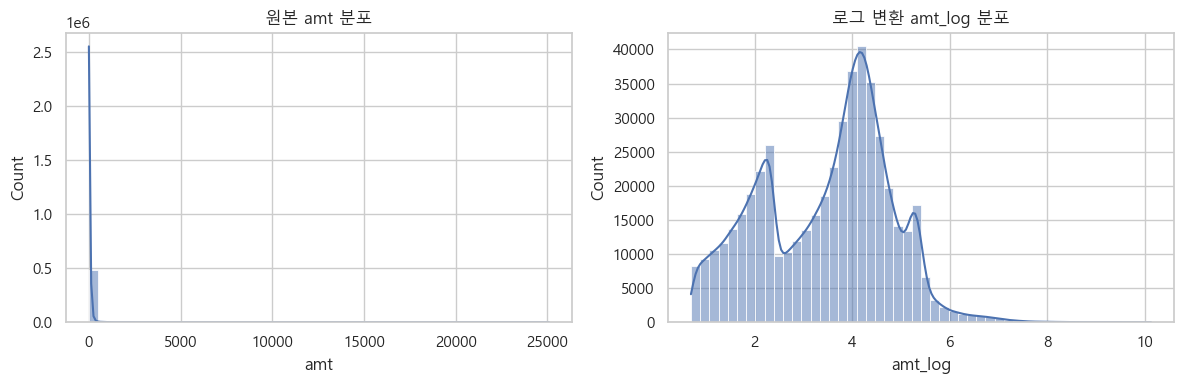

In [66]:
# 로그 변환 전후 시각화
plt.figure(figsize=(12,4))

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.subplot(1,2,1)
sns.histplot(df_fraud['amt'], bins=50, kde=True)
plt.title("원본 amt 분포")

plt.subplot(1,2,2)
sns.histplot(df_log['amt_log'], bins=50, kde=True)
plt.title("로그 변환 amt_log 분포")

plt.tight_layout()
plt.show()


**(2) 로그 변환**
- 원본 `amt` 히스토그램
  - 극단적으로 오른쪽 꼬리가 긴 분포를 보인다. 
  - 대부분 거래는 소액에 집중되이ㅓ 있으며, 일부 고액 거래가 전체 분포를 크게 왜곡하고있다.
  - 이는 금융 거래 데이터에서 일반적으로 나타나는 자연스러운 현상으로, 고액 거래 자체를 오류로 판단하기 어렵다.
- 로그 변환 후
  - 로그 변환 후 거래 금액 분포는 한쪽으로 치우친 형태가 완화되며 비교적 안정적인 분포를 보인다.
  - 극단값이 존재하더라도 값이 압축되기 때문에, 모델 학습시 고액 거래의 영향력이 과도하게 커지는 문제를 줄일 수 있다.
- 로그 변환은 데이터 손실 없이 극단값의 영향을 완화할 수 있어, 금융 거래처럼 고액 거래가 자연히 존재하는 데이터에 더 적절한 처리 방식이라고 할 수 있다.

➡️ 로그 변환 방식 채택

In [67]:
try:
    df_fraud['amt_log'] = np.log1p(df_fraud['amt'])     # 로그 변환한 amt 추가
    df_fraud = df_fraud.drop(columns=['amt'])    # 기존 amt 컬럼 삭제
except KeyError:
    pass

print("데이터 컬럼 확인:", df_fraud.columns.tolist())

데이터 컬럼 확인: ['merchant', 'category', 'gender', 'city', 'state', 'city_pop', 'job', 'is_fraud', 'distance_km', 'trans_hour', 'is_night_txn', 'age', 'amt_log']


## 데이터 타입 변환

### 📌 원 핫 인코딩

In [68]:
categorical_cols = df_log.select_dtypes(include=['object']).columns
print('컬럼별 고유값 개수')
print(df_log[categorical_cols].nunique())

# 컬럼 분류
high_cardinality = ['merchant', 'city', 'job'] 
low_cardinality = ['category', 'gender', 'state']

for col in high_cardinality:
    freq_encoding = df_log[col].value_counts()
    df_log[col + '_freq'] = df_log[col].map(freq_encoding)
df_log = df_log.drop(columns=high_cardinality)

# 원 핫 인코딩
df_encoded = pd.get_dummies(df_log, columns=low_cardinality, drop_first=True)

print('\n인코딩 후 데이터 크기')
print(df_encoded.shape)

컬럼별 고유값 개수
merchant    693
category     14
gender        2
city        121
state        44
job         110
dtype: int64

인코딩 후 데이터 크기
(491134, 68)


**원 핫 인코딩을 진행한 이유**
- `category`, `gender`, `state`와 같은 명목형 변수들을 독립된 컬럼으로 분리하여 크기 왜곡을 방지했다
- 이상탐지에서 자주 사용되는 KNN이나 SVM같은 모델의 성능을 향상시키기 위해 사용했다
- `drop_first=True`옵션을 통해 다중공선성 문제를 해결했다

### 📌 데이터 분할

In [69]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=['is_fraud'])
y = df_encoded['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'훈련 데이터 크기: {X_train.shape}')
print(f'테스트 데이터 크기: {X_test.shape}')

print('\n--- 타겟 변수 비율 확인 (stratify 결과) ---')
print(f'훈련 셋 사기 비율:\n{y_train.value_counts(normalize=True)}')

훈련 데이터 크기: (392907, 67)
테스트 데이터 크기: (98227, 67)

--- 타겟 변수 비율 확인 (stratify 결과) ---
훈련 셋 사기 비율:
is_fraud
0    0.997468
1    0.002532
Name: proportion, dtype: float64


### 📌 타겟 불균형 해결

In [70]:
from imblearn.over_sampling import SMOTE

# SMOTE 객체 생성
smote = SMOTE(random_state=42)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print(f'오버샘플링 전 훈련 데이터 크기: {X_train.shape}')
print(f'오버샘플링 후 훈련 데이터 크기: {X_train_over.shape}')

print('\n---타겟 불균형 해결 후 비율 확인 ---')
print(f'오버샘플링 후 사기 비율:\n{y_train_over.value_counts(normalize=True)}')

오버샘플링 전 훈련 데이터 크기: (392907, 67)
오버샘플링 후 훈련 데이터 크기: (783824, 67)

---타겟 불균형 해결 후 비율 확인 ---
오버샘플링 후 사기 비율:
is_fraud
0    0.5
1    0.5
Name: proportion, dtype: float64


- 오버샘플링은 적은 데이터를 늘려서 많은 쪽에 맞추는 것이고, 언더샘플링은 많은쪽을 삭제해서 적은쪽에 맞추는 것이다.
- 사기 거래 데이터의 희소성 문제를 해결하기 위해 STMOME 오버샘플링을 적용하였다. 

### 📌 스케일링

In [71]:
# 로버스트 스케일러
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train_over)

X_test_scaled = scaler.transform(X_test)

print('--- 스케일링 적용 후 데이터 ---')
import pandas as pd
print(pd.DataFrame(X_train_scaled, columns=X.columns).head())

--- 스케일링 적용 후 데이터 ---
        amt  city_pop  distance_km  trans_hour  is_night_txn     age  \
0 -0.194455  3.656457    -0.072603    0.533333           0.0  0.0625   
1 -0.246942 -0.106680     0.939753    0.466667          -1.0  0.6250   
2 -0.040215 -0.110162    -0.503569   -0.533333          -1.0 -0.3750   
3 -0.077940 -0.099291    -0.426300   -0.200000          -1.0 -0.8125   
4  0.058228  9.884514     0.400641    0.266667          -1.0  0.2500   

    amt_log  merchant_freq  city_freq  job_freq  ...  state_SD  state_TN  \
0 -0.467748       0.841026   0.972527 -0.004087  ...       0.0       0.0   
1 -1.170422      -0.758974  -0.009615 -0.978202  ...       0.0       0.0   
2 -0.018204       0.112821  -0.015110  4.952316  ...       0.0       0.0   
3 -0.086903       0.697436   1.004121  0.027248  ...       0.0       0.0   
4  0.116062      -0.784615   6.000000  3.995913  ...       0.0       0.0   

   state_TX  state_UT  state_VA  state_VT  state_WA  state_WI  state_WV  \
0       0.0  

- RobustScaler는 중앙값과 IQR을 사용하는 스케일링 방법이다
  - 사기 거래는 보통 이상치를 포함한 경우가 많은데, 로버스트 스케일러는 이러한 이상치의 영향을 최소화하면서 나머지 데이터의 변별력을 유지할 수 있다
- StandardScaler는 평균과 표준편차를 사용하여 정규분포로 만드는 스케일링 방법이다
  - PCA를 수행할 때 가장 표준적으로 사용하지만, 하버사인 거리처럼 극단값이 있는 경우 평균이 왜곡될 수 있다
- MinMaxScaler는 0과 1사위로 범위를 압축하는 스케일링 방법이다
  - 이상치가 존재하면 정상 데이터들이 아주 좁은 범위에 뭉치게 되기 때문에 모델이 특징을 구분하기 어려워진다.

➡️ 로버스트 스케일러 채택

## PCA

In [72]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA()
pca.fit(X_train_scaled)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 

print(f'전체 정보의 95%를 유지하기 위한 주성분 개수: {d}')

pca_final = PCA(n_components=d)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

print(f'--- PCA 적용 후 데이터 크기 ---')
print(f'학습 데이터: {X_train_pca.shape}')
print(f'테스트 데이터: {X_test_pca.shape}')

전체 정보의 95%를 유지하기 위한 주성분 개수: 8
--- PCA 적용 후 데이터 크기 ---
학습 데이터: (783824, 8)
테스트 데이터: (98227, 8)


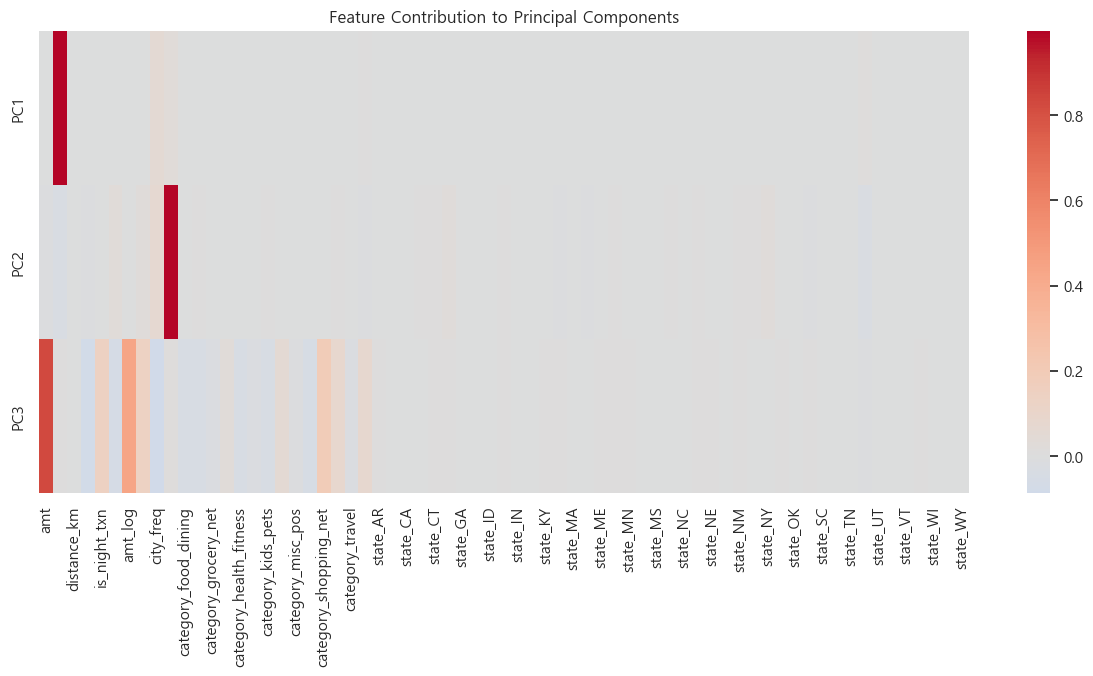

In [93]:
# 주성분 변수 확인
feature_names = df_encoded.drop(columns=['is_fraud']).columns

components_df = pd.DataFrame(
    pca_final.components_, 
    columns=feature_names, 
    index=[f'PC{i+1}' for i in range(pca_final.n_components_)]
)

plt.figure(figsize=(15, 6))
sns.heatmap(components_df.iloc[:3], cmap='coolwarm', center=0)
plt.title('Feature Contribution to Principal Components')
plt.show()

# 3. EDA

## 단변량 분석

In [74]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 수치형/범주형 컬럼 분리
def split_cols(df, target=None):
    tmp = df.drop(columns=[target]) if target and target in df.columns else df.copy()
    num_cols = tmp.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = tmp.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    return num_cols, cat_cols

In [75]:
# 데이터 개괄 확인
def overview(df, target=None, head=5):
    print('--- Shape ---')
    print(df.shape)

    print('\n--- Dtypes ---')
    print(df.dtypes.value_counts())

    print('\n--- Missing ---')
    miss = df.isnull().sum().sort_values(ascending=False)
    print(miss.head(10))
    print(f'총 결측치 수: {miss.sum()}')

    print('\n--- Duplicates ---')
    print('중복 행 수:', df.duplicated().sum())

    if target and target in df.columns:
        print('\n--- Target Distribution ---')
        print(df[target].value_counts())
        print('\n--- Target Ratio(%) ---')
        print((df[target].value_counts(normalize=True) * 100).round(4))

    print('\n--- Head ---')
    display(df.head(head))

In [76]:
# 수치형 단변량
def univariate_numeric(df, cols, bins=50):
    for col in cols:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        sns.histplot(df[col].dropna(), bins=bins, kde=True)
        plt.title(f'{col} - Histogram')

        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col].dropna())
        plt.title(f'{col} - Boxplot')

        plt.tight_layout()
        plt.show()


In [77]:
# 범주형 단변량
def univariate_categorical(df, cols, top_n=10):
    for col in cols:
        vc = df[col].value_counts(dropna=False).head(top_n)
        print(f'\n--- {col} (Top {top_n}) ---')
        print(vc)

        plt.figure(figsize=(10, 4))
        sns.countplot(
            y=col,
            data=df,
            order=df[col].value_counts().head(top_n).index
        )
        plt.title(f'{col} - Top {top_n} Categories')
        plt.tight_layout()
        plt.show()

In [78]:
# 단변량 EDA
def eda_univariate(df, target=None, num_cols=None, cat_cols=None,
                   bins=50, top_n=10, max_num=12, max_cat=8):
    overview(df, target=target)

    if num_cols is None or cat_cols is None:
        num_cols, cat_cols = split_cols(df, target=target)

    num_cols_show = num_cols[:max_num]
    cat_cols_show = cat_cols[:max_cat]

    print('\n--- Numeric Columns ---')
    print(num_cols_show)

    print('\n--- Categorical Columns ---')
    print(cat_cols_show)

    if len(num_cols_show) > 0:
        univariate_numeric(df, num_cols_show, bins=bins)

    if len(cat_cols_show) > 0:
        univariate_categorical(df, cat_cols_show, top_n=top_n)

--- Shape ---
(491134, 13)

--- Dtypes ---
object     6
int64      4
float64    2
int32      1
Name: count, dtype: int64

--- Missing ---
merchant       0
category       0
gender         0
city           0
state          0
city_pop       0
job            0
is_fraud       0
distance_km    0
trans_hour     0
dtype: int64
총 결측치 수: 0

--- Duplicates ---
중복 행 수: 0

--- Target Distribution ---
is_fraud
0    489890
1      1244
Name: count, dtype: int64

--- Target Ratio(%) ---
is_fraud
0    99.7467
1     0.2533
Name: proportion, dtype: float64

--- Head ---


,merchant,category,gender,city,state,city_pop,job,is_fraud,distance_km,trans_hour,is_night_txn,age,amt_log
0,"fraud_Heller, Gutmann and Zieme",grocery_pos,F,Orient,WA,149,Special educational needs teacher,0,30.212176,0,1,40,4.684259
1,"fraud_Schultz, Simonis and Little",grocery_pos,M,Elizabeth,NJ,124967,Operational researcher,0,84.702120,0,1,38,3.822317
2,fraud_Kling-Grant,grocery_net,F,Plainfield,NJ,71485,Leisure centre manager,0,67.847742,0,1,44,3.856087
3,fraud_Deckow-O'Conner,grocery_pos,M,Romulus,MI,31515,Police officer,0,22.303906,0,1,47,4.175771
4,fraud_Balistreri-Nader,misc_pos,F,Baton Rouge,LA,378909,"Designer, furniture",0,79.591943,0,1,41,3.280159



--- Numeric Columns ---
['city_pop', 'distance_km', 'is_night_txn', 'age', 'amt_log']

--- Categorical Columns ---
['merchant', 'category', 'gender', 'city', 'state', 'job']


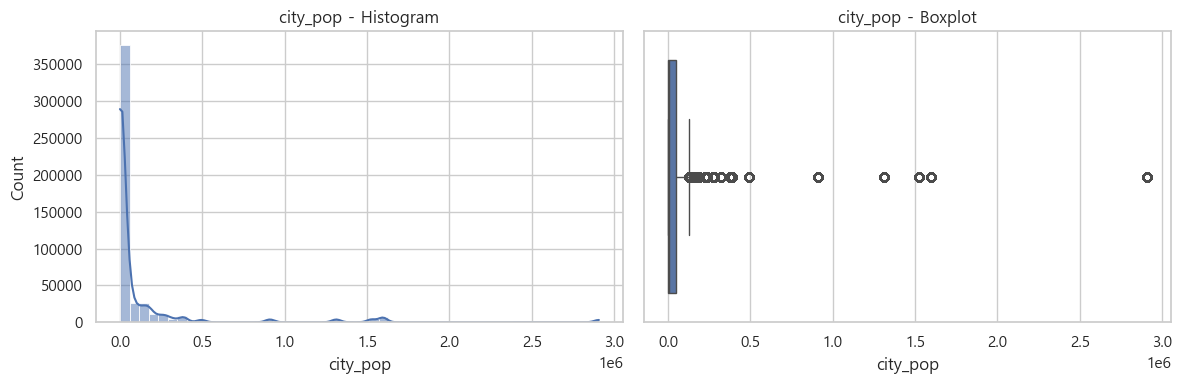

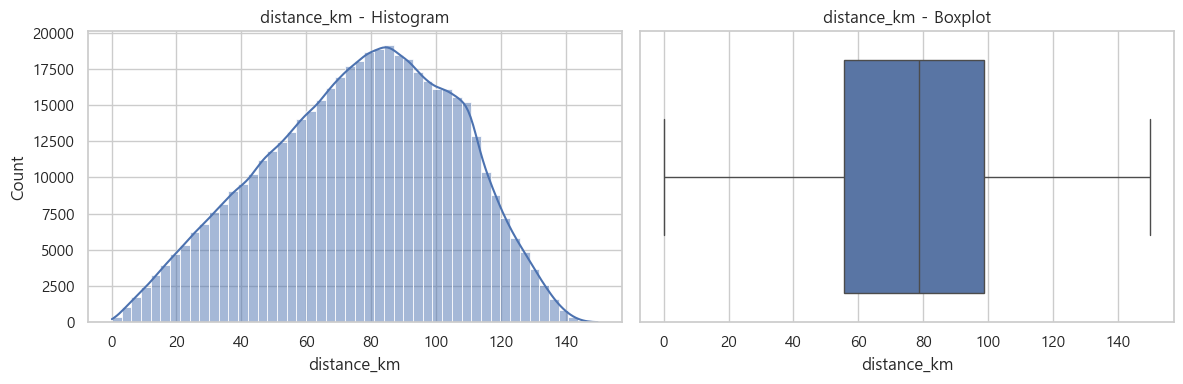

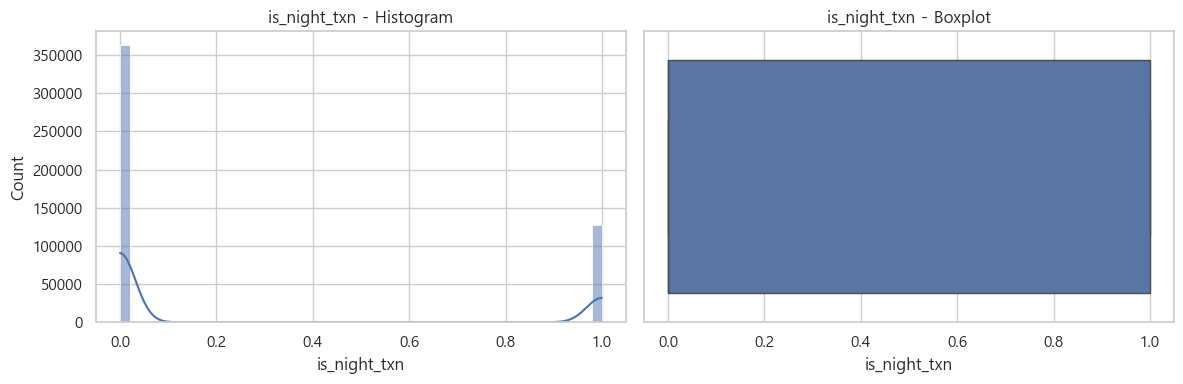

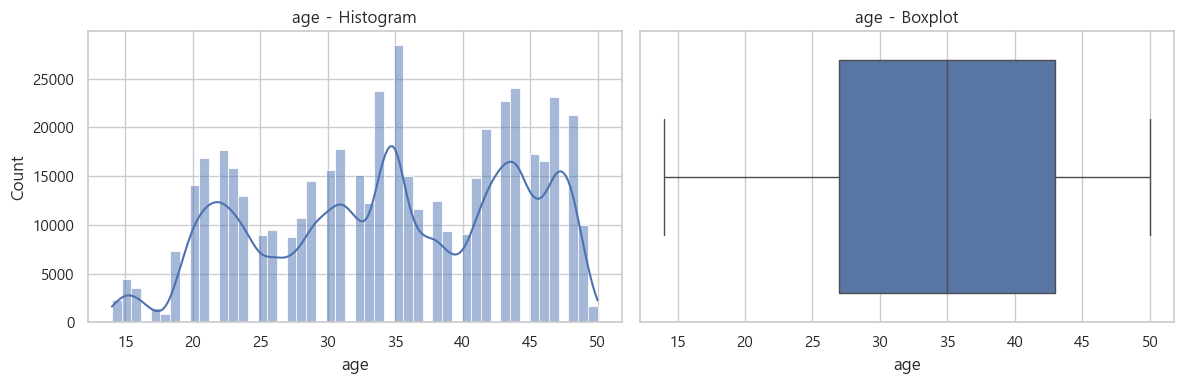

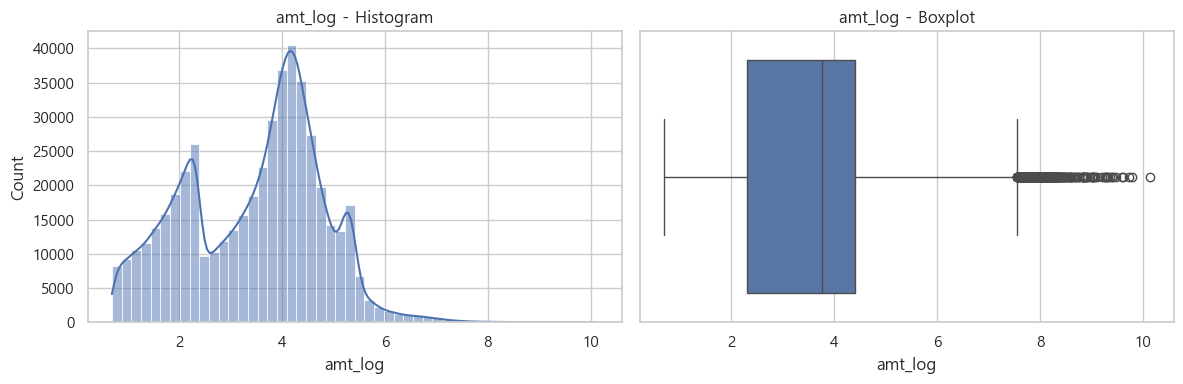


--- merchant (Top 10) ---
merchant
fraud_Kilback LLC                       1602
fraud_Cormier LLC                       1455
fraud_Kuhn LLC                          1446
fraud_Schumm PLC                        1392
fraud_Boyer PLC                         1375
fraud_Dickinson Ltd                     1343
fraud_Hickle Group                      1026
fraud_Baumbach, Hodkiewicz and Walsh    1016
fraud_Willms, Kris and Bergnaum         1006
fraud_Stoltenberg-Beatty                1003
Name: count, dtype: int64


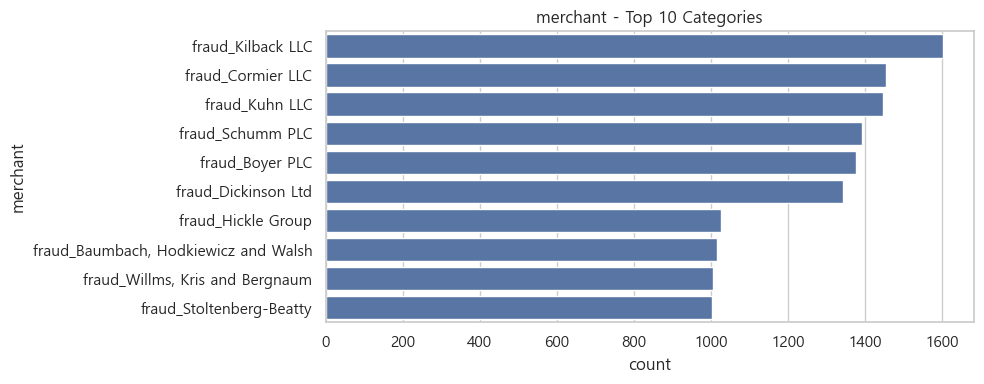


--- category (Top 10) ---
category
shopping_pos     48345
gas_transport    46029
home             43340
grocery_pos      42722
kids_pets        40295
shopping_net     39179
food_dining      35980
personal_care    35513
entertainment    33619
misc_pos         32411
Name: count, dtype: int64


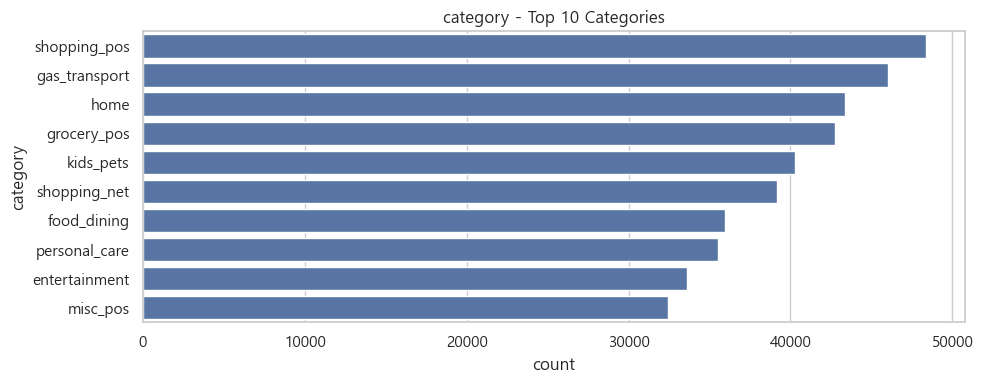


--- gender (Top 10) ---
gender
F    352445
M    138689
Name: count, dtype: int64


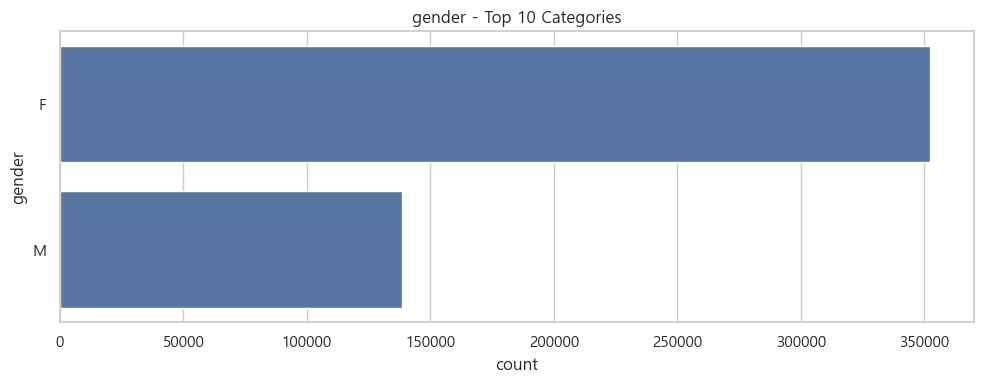


--- city (Top 10) ---
city
Birmingham      8029
San Antonio     7305
Meridian        7289
Lomax           4392
Clarks Mills    4392
Walnut Ridge    4386
Thompson        4386
Reno            4386
De Witt         4385
Sebring         4385
Name: count, dtype: int64


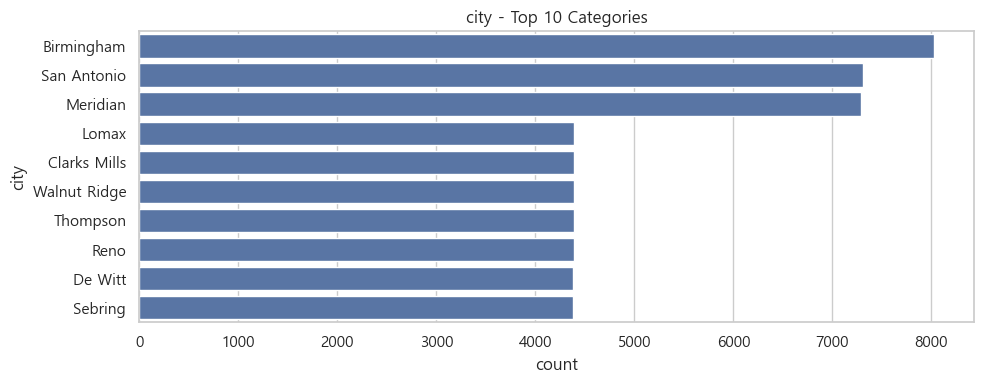


--- state (Top 10) ---
state
TX    49621
MI    28451
NY    23368
PA    20458
WA    19691
AL    18967
NC    18957
AR    17518
SC    16062
IL    16054
Name: count, dtype: int64


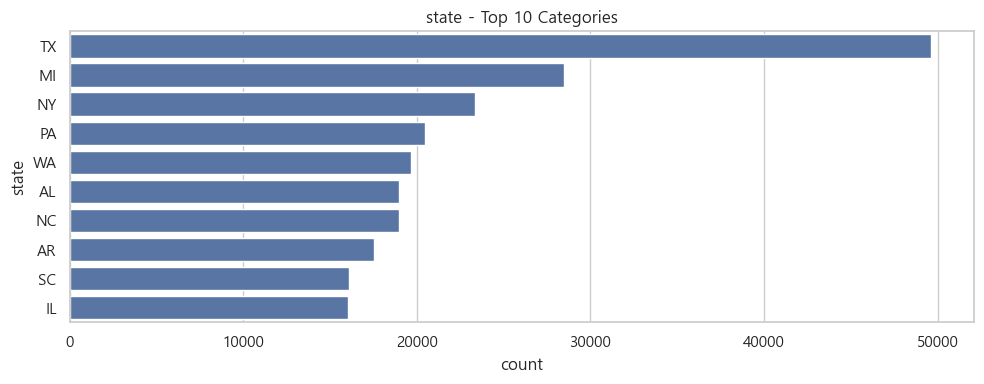


--- job (Top 10) ---
job
Environmental consultant    8777
Comptroller                 8766
Immunologist                8760
Water engineer              8740
Film/video editor           8035
Materials engineer          8024
Firefighter                 8021
Chief Executive Officer     8007
Surveyor, land/geomatics    7312
Musician                    7305
Name: count, dtype: int64


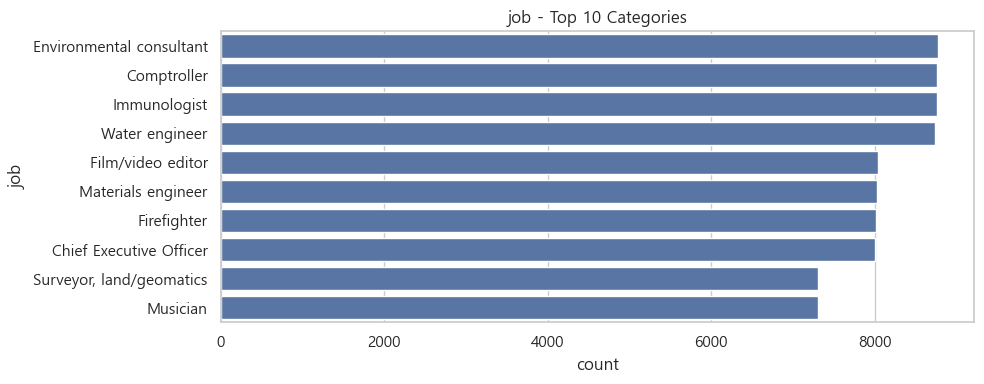

In [79]:
eda_univariate(df_fraud, target=target_col)

- 단변량 분석 결과, 이 데이터는 사기 거래가 극히 적은 불균형 구조를 가지며, 거래 금액 변수는 오른쪽 꼬리가 긴 비대칭 분포와 다수의 극단값을 포함하고 있다.
- 이는 금융 거래 데이터의 자연스러운 특성으로 판단되며, 단순 이상치 제거보다는 로그 변환을 통한 분포 안정화가 더 적절하다.
- 또한 변수간 스케일 차이가 크기 때문에, 모델 학습을 할 때는 스케일링 작업이 필요하다.

## 이변량 분석

### 수치형 변수 vs `is_fraud`

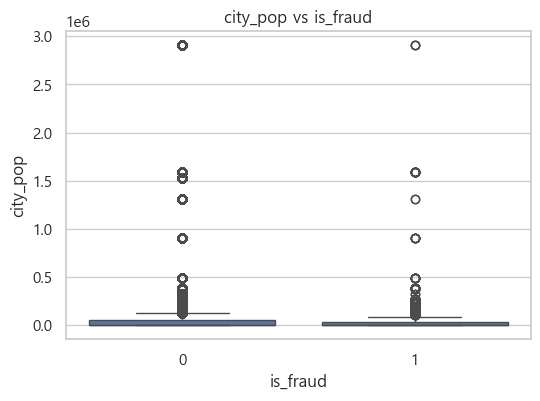

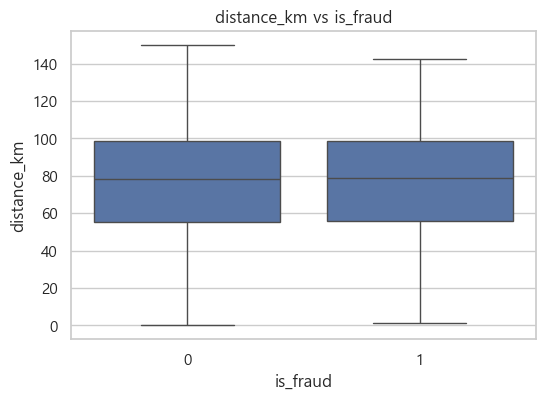

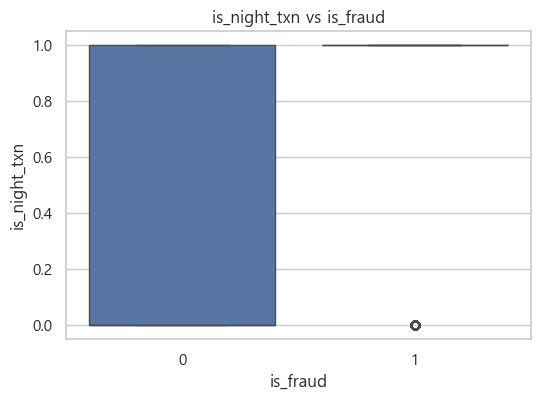

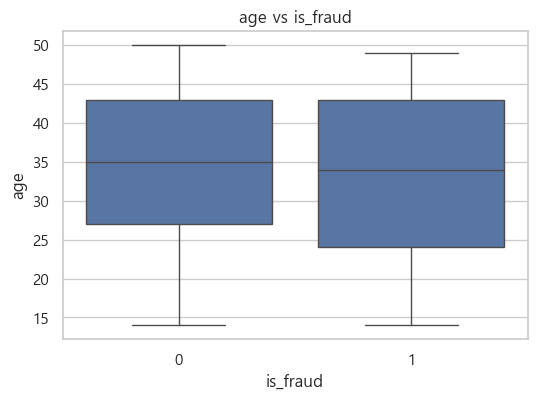

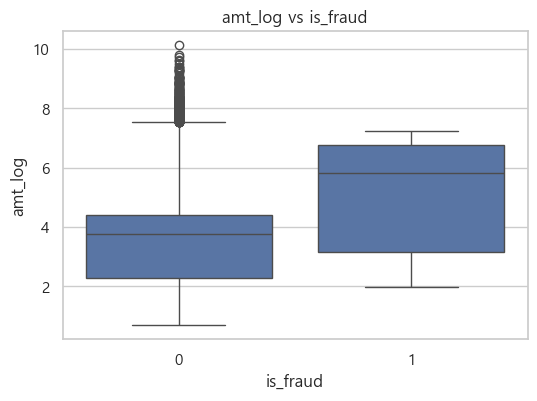

In [80]:
num_cols, cat_cols = split_cols(df_fraud, target=target_col)

for col in num_cols:
    if col == target_col:
        continue
        
    plt.figure(figsize=(6,4))
    sns.boxplot(x=target_col, y=col, data=df_fraud)
    plt.title(f'{col} vs {target_col}')
    plt.show()

In [81]:
df_fraud.groupby(target_col)[num_cols].mean().T

is_fraud,0,1
city_pop,121497.939668,79763.713023
distance_km,76.377667,76.763829
is_night_txn,0.259191,0.868167
age,34.673612,33.829582
amt_log,3.463174,5.342417


In [82]:
# T-Test
from scipy.stats import ttest_ind

for col in num_cols:
    if col == target_col:
        continue
    
    group0 = df_fraud[df_fraud[target_col]==0][col]
    group1 = df_fraud[df_fraud[target_col]==1][col]
    
    stat, p = ttest_ind(group0, group1, equal_var=False)
    
    print(f'{col} | p-value: {p:.6f}')

city_pop | p-value: 0.000000
distance_km | p-value: 0.635859
is_night_txn | p-value: 0.000000
age | p-value: 0.001936
amt_log | p-value: 0.000000


### 범주형 변수 vs `is_fraud`

In [83]:
for col in cat_cols:
    fraud_rate = (
        df_fraud.groupby(col)[target_col]
        .mean()
        .sort_values(ascending=False)
        .head(10)
    )
    
    print(f'\n--- {col} 상위 사기율 ---')
    print(fraud_rate)


--- merchant 상위 사기율 ---
merchant
fraud_Moen, Reinger and Murphy             0.013269
fraud_Bednar Group                         0.012876
fraud_Kovacek Ltd                          0.011628
fraud_Gottlieb, Considine and Schultz      0.011480
fraud_Langworth, Boehm and Gulgowski       0.011421
fraud_Altenwerth, Cartwright and Koss      0.011335
fraud_Wolf Inc                             0.011125
fraud_Bashirian Group                      0.010485
fraud_Kerluke, Considine and Macejkovic    0.010225
fraud_Goldner, Kovacek and Abbott          0.010158
Name: is_fraud, dtype: float64

--- category 상위 사기율 ---
category
shopping_net     0.006177
grocery_pos      0.005056
misc_net         0.004329
shopping_pos     0.002772
gas_transport    0.002194
travel           0.001902
misc_pos         0.001759
food_dining      0.001723
kids_pets        0.001688
home             0.001661
Name: is_fraud, dtype: float64

--- gender 상위 사기율 ---
gender
M    0.002855
F    0.002406
Name: is_fraud, dtype: float64



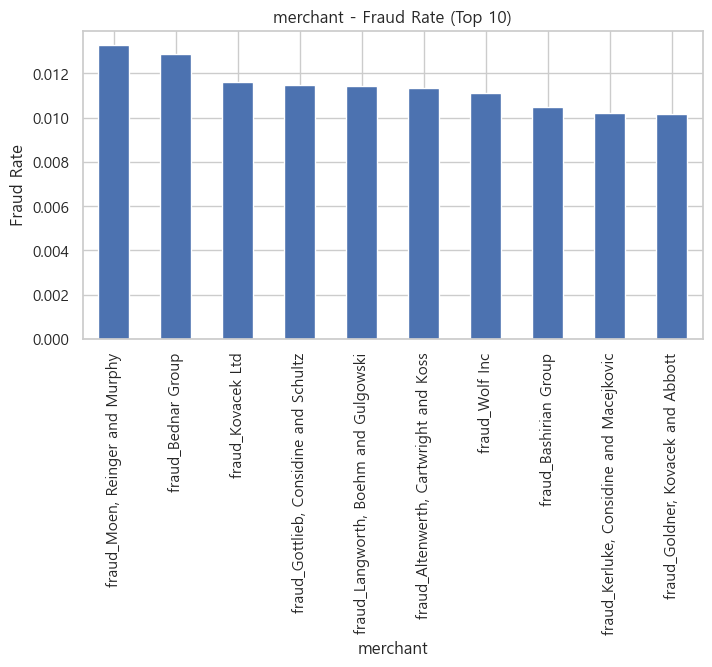

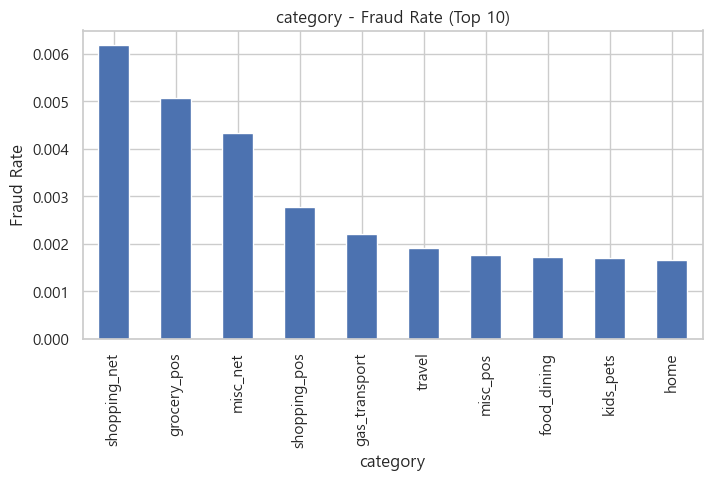

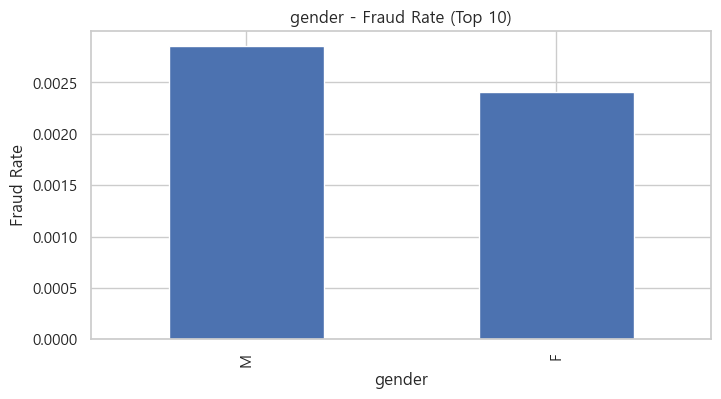

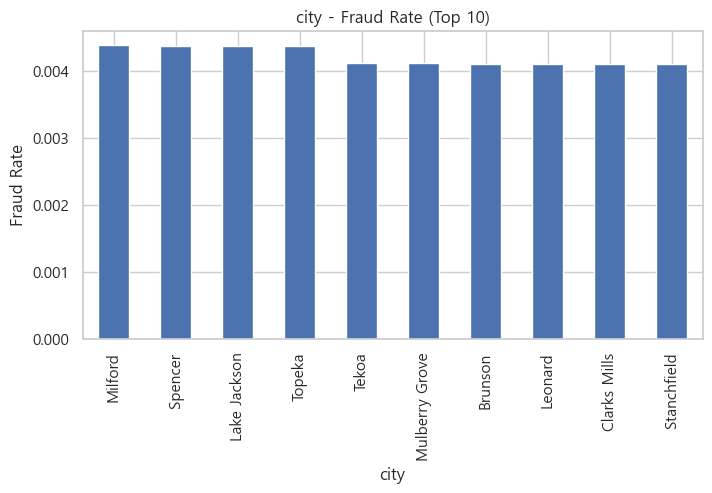

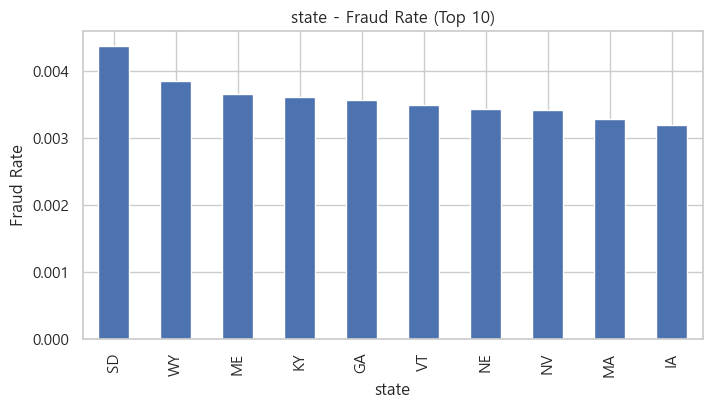

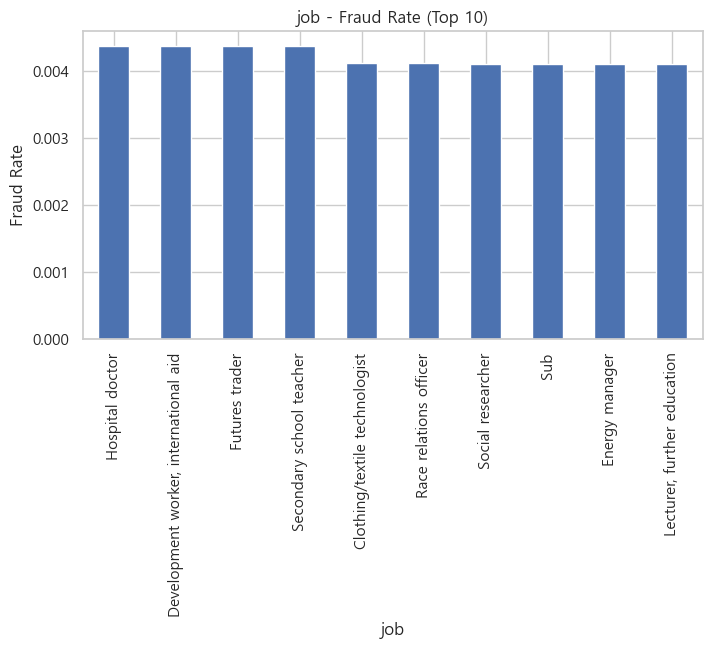

In [84]:
for col in cat_cols:
    fraud_rate = (
        df_fraud.groupby(col)[target_col]
        .mean()
        .sort_values(ascending=False)
        .head(10)
    )
    
    plt.figure(figsize=(8,4))
    fraud_rate.plot(kind='bar')
    plt.title(f'{col} - Fraud Rate (Top 10)')
    plt.ylabel('Fraud Rate')
    plt.show()

In [85]:
from scipy.stats import chi2_contingency

for col in cat_cols:
    table = pd.crosstab(df_fraud[col], df_fraud[target_col])
    chi2, p, dof, expected = chi2_contingency(table)
    print(f'{col} | p-value: {p:.6f}')

merchant | p-value: 0.000000
category | p-value: 0.000000
gender | p-value: 0.005300
city | p-value: 0.000000
state | p-value: 0.020931
job | p-value: 0.000000


## 다변량 분석

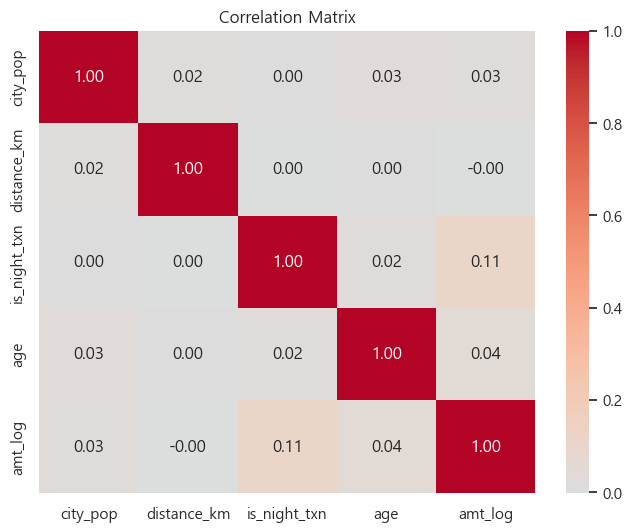

In [86]:
# 변수간 상관관계 분석
num_cols, cat_cols = split_cols(df_fraud, target=target_col)

corr_matrix = df_fraud[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

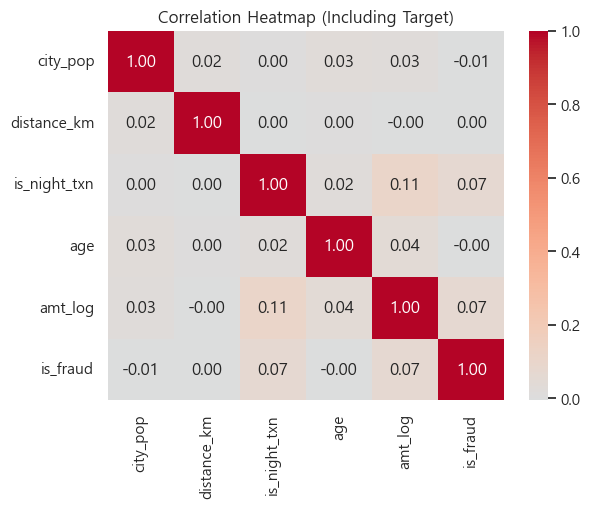

In [87]:
# 타겟변수 포함 상관관계 분석
num_cols_with_target = num_cols + ['is_fraud']
corr = df_fraud[num_cols_with_target].corr()

sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Including Target)')
plt.show()

In [88]:
# 높은 상관관계를 가진 변수 쌍 추출
corr_matrix = df_fraud[num_cols].corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr_pairs = (
    upper.stack()
    .sort_values(ascending=False)
)

high_corr_pairs[high_corr_pairs > 0.8]

Series([], dtype: float64)

-> 상관 계수 0.8 이상의 강한 상관관계를 가진 변수가 없다

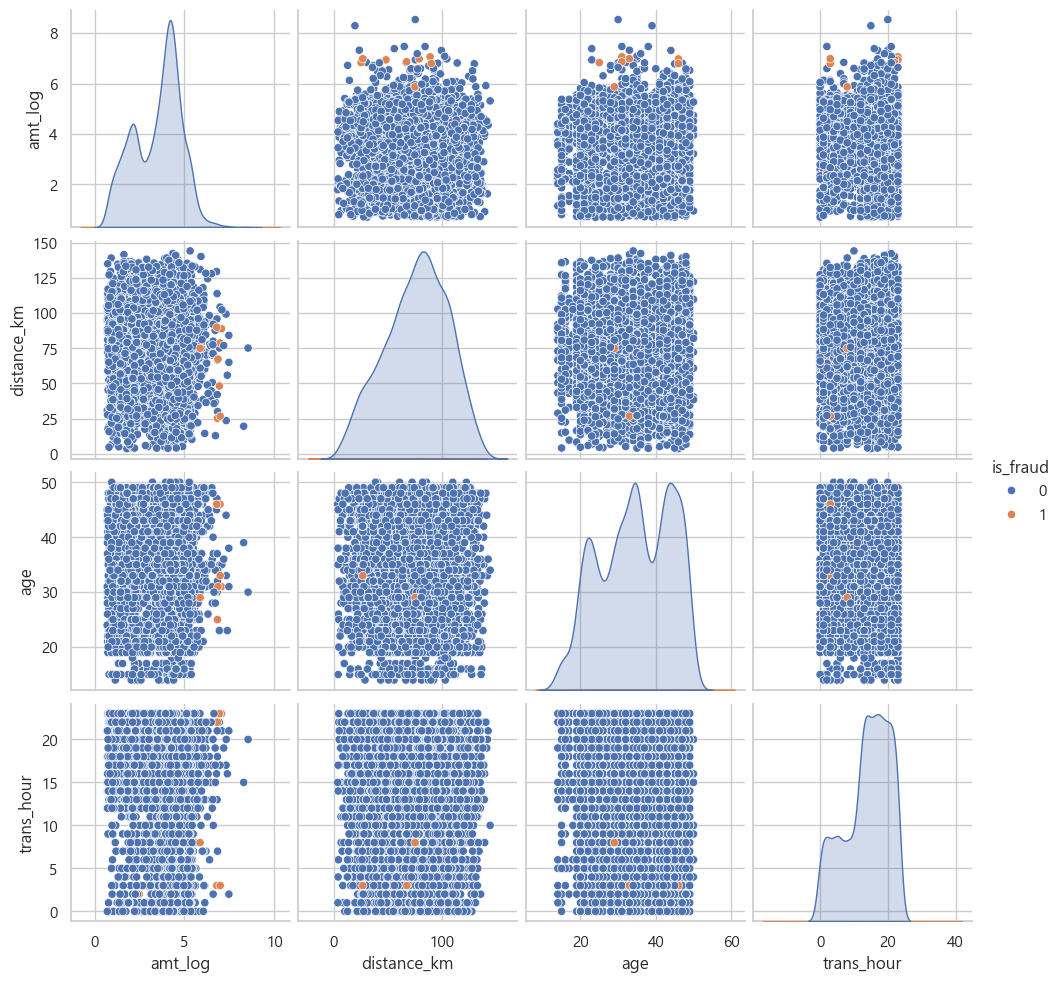

In [89]:
# Pairplot
sample_df = df_fraud.sample(n=5000, random_state=42)

key_cols = ['amt_log', 'distance_km', 'age', 'trans_hour', 'is_fraud']

sns.pairplot(sample_df[key_cols], hue='is_fraud', diag_kind='kde')
plt.show()

- 모든 변수와 상관관계가 매우 낮은데, 상관계수는 선형 관계만 측정하기 때문에 이 데이터는 비선형 패턴일 가능성이 있다.Pairplot 산점도를 확인해보면 이를 확인해볼 수 있다.
- `distance_km`의 상관계수가 0인 이뉴는 단순 선형 상관이 없으며, 특정 임계값 이상에서 급증할 가능성이 있음을 시사한다.

# 4. 모델학습 및 평가

## XGBoost

c:\Users\User\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [03:26:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- XGBoost 모델 평가 결과 ---
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     97978
           1       0.04      0.76      0.08       249

    accuracy                           0.95     98227
   macro avg       0.52      0.86      0.53     98227
weighted avg       1.00      0.95      0.97     98227

ROC-AUC Score: 0.9087


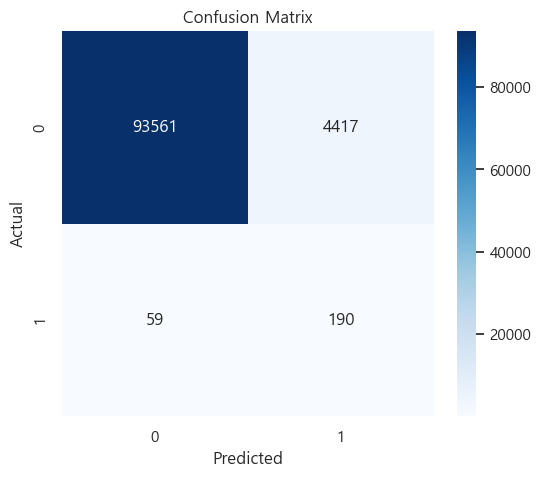

In [94]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train_pca, y_train_over)

y_pred = xgb_model.predict(X_test_pca)
y_pred_proba = xgb_model.predict_proba(X_test_pca)[:, 1]

print('--- XGBoost 모델 평가 결과 ---')
print(classification_report(y_test, y_pred))

# ROC-AUC 점수 확인
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC Score: {auc_score:.4f}')

# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

- Recall점수는 0.76으로 나쁘지 않게 나왔지만, Precision 점수가 0.04가 나와 정밀도가 매우 아쉬운 것을 확인할 수 있다.
- 비즈니스적 관점에서는 오탐이 많아 실제 결제를 할 경우 불편을 겪을 수 있다.

--- 임계값을 0.8로 변경한 결과 ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     97978
           1       0.20      0.64      0.30       249

    accuracy                           0.99     98227
   macro avg       0.60      0.82      0.65     98227
weighted avg       1.00      0.99      0.99     98227



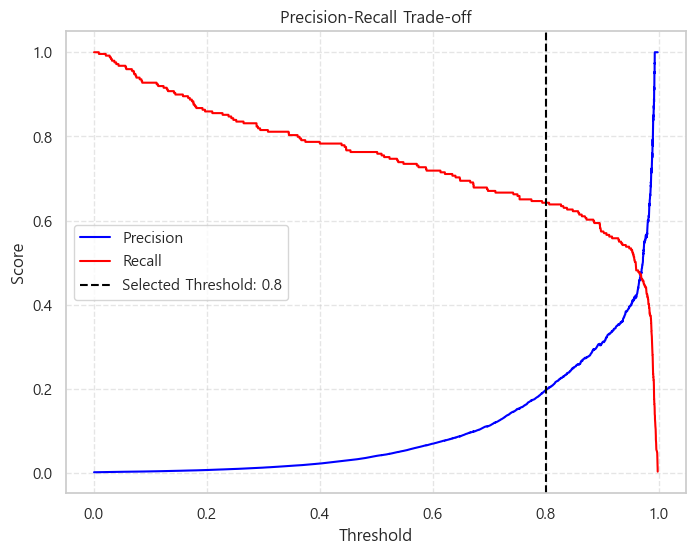

In [ ]:
# 하이퍼파라미터 튜닝
from sklearn.metrics import precision_recall_curve

y_scores = xgb_model.predict_proba(X_test_pca)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

new_threshold = 0.8
y_pred_new = (y_scores >= new_threshold).astype(int)

print(f'--- 임계값을 {new_threshold}로 변경한 결과 ---')
print(classification_report(y_test, y_pred_new))

# 정밀도-재현율 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label='Precision', color='blue')
plt.plot(thresholds, recalls[:-1], label='Recall', color='red')
plt.axvline(new_threshold, color='black', linestyle='--', label=f'Selected Threshold: {new_threshold}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Trade-off')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

- 임계값 조정을 통해 0.04에서 0.20으로 정밀도를 향상시켜 오탐 비율을 줄였다.
- 정밀도를 높이는 과정에서 재현율이 76%에서 64%로 하락하였다. 이는 탐지 시스템의 안전성과 편의성 사이의 균형을 맞추는 과정에서 하락한 것으로 보인다.